# Analytics for Unstructured Data - Assignment 1

## Group Project

**Problem Statement** : Wou have been hired as an analytics consultant by JD power and Associates, who wants to perform a competitive analysis of the entry level luxury car market in the USA. Your job is to give advice/insights to your client based on the analysis of social media conversations. 

Group Members: 
1. Mayank Gupta (mg66426)
2. Rachana Aithal ()
3. Rahull Borana (rb47374)
4. Saiyam Shah ()
5. Sanjana Nayak ()



In [5]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
from sklearn.linear_model import LinearRegression
from itertools import product
%matplotlib inline
sns.set(color_codes = True)

### Data Scraping: Write a scraper using Python to fetch messages posted in Edmunds.com discussion forums. The scraper output should be a .csv file with the following columns: date and message (even though you will only use the messages in your analysis). Fetch around 5000 posts about cars from the Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

In [10]:
# Scraper code
# We have used a scrapy scraper for this exercise as we figured it was a fast way to scrape the data one-time. 
# We will be attaching the scrapy project folder along to run the scraper in case needed
# We can run it by running "scrapy crawl scraper -o output.csv" in the same folder in which we see items and settings and middlewares files
# However, just attaching the scrapy spider code here for reference 

""" 
import scrapy
from scraper.items import ScraperItem
from scrapy.selector import Selector
import requests
import re
import urllib.request
from urllib.parse import urlparse
from w3lib.html import  remove_tags
import unicodedata
import datetime
from urllib.parse import urljoin
from scraper import settings
import logging
from w3lib.http import basic_auth_header
from scrapy import signals
from pydispatch import dispatcher
from scrapy.http import FormRequest
from lxml.html import fromstring
from bs4 import BeautifulSoup


class scraper(scrapy.Spider):
    name="scraper"
    allowed_domains = ["forums.edmunds.com"]
    
    PROJECT_ROOT=settings.PROJECT_ROOT

    def start_requests(self):
        urllist=[]
        pages= range(7,107)
        for i in pages:
            urllist.append('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'.format(i))
        
        for i in urllist:
            yield scrapy.Request(i, callback=self.parse)


    def parse(self, response):
        hxs = Selector(response)
        for quote in hxs.xpath('//div[@class="Comment"]'):
            bodies = BeautifulSoup(' '.join(quote.xpath('.//div[@class="Message userContent"]//text()').extract()))
            bodies = bodies.get_text().strip()
            dates= quote.xpath('.//div//time/@title').extract_first()
            dates=' '.join(dates.split(' ')[:-1])
            authors= quote.xpath('.//div//span[@class="Author"]//@title').extract_first()
            item= ScraperItem()
            item["author"]=authors
            item["body"]=bodies
            item["dates"]=dates
            yield item

"""

#We scraped 17500 records from Jan 2004 to March 2008

' \nimport scrapy\nfrom scraper.items import ScraperItem\nfrom scrapy.selector import Selector\nimport requests\nimport re\nimport urllib.request\nfrom urllib.parse import urlparse\nfrom w3lib.html import  remove_tags\nimport unicodedata\nimport datetime\nfrom urllib.parse import urljoin\nfrom scraper import settings\nimport logging\nfrom w3lib.http import basic_auth_header\nfrom scrapy import signals\nfrom pydispatch import dispatcher\nfrom scrapy.http import FormRequest\nfrom lxml.html import fromstring\nfrom bs4 import BeautifulSoup\n\n\nclass scraper(scrapy.Spider):\n    name="scraper"\n    allowed_domains = ["forums.edmunds.com"]\n    \n    PROJECT_ROOT=settings.PROJECT_ROOT\n\n    def start_requests(self):\n        urllist=[]\n        pages= range(7,107)\n        for i in pages:\n            urllist.append(\'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}\'.format(i))\n        \n        for i in urllist:\n            yield scrapy.Req

### Task A: Test if the data support Zipf’s law econometrically. Additionally plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

In [6]:
#helper functions
# function to read in a file(txt,csv, xlsx, json) and convert to dataframe

def read_file(filepath):
    if re.search('txt',filepath):
        df = pd.read_csv(filepath)
    elif re.search('csv',filepath) or re.search('txt',filepath):
        df = pd.read_csv(filepath)
    else:
        df = df = pd.read_excel(filepath)
    return df

#function for basic description of dataset (head, info, describe,null,columns)
def summarize_data(data,metric):
    if metric == 'head':
        print(data.head())
    elif metric == 'info':
        print(data.info())
    elif metric == 'describe':
        print(data.describe())
    else:
        total = data.isnull().sum().sort_values(ascending = False)
        percent = (data.isnull().sum()/data.iloc[:,1].count()).sort_values(ascending = False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        print(missing_data.head(20))

#function to split sentence into separate words
def split_words(reviews):
    corpus = ""
    for words in reviews:
        corpus += words
    return corpus


#count frequency and sort highest to lowest
def freq_count(data,n):
    #converting the entire text to lower string and storing it in a single string
    corpus = split_words(data).lower()

    #Separating out tokens/words from corpus
    tokens = nltk.word_tokenize(corpus)

    #creating a dict of word frequencies 
    word_frequencies =Counter(tokens)
    
    #Create top n words dict
    top_n_words= dict(word_frequencies.most_common(n))
    
    word_frequency_tuples = list(top_n_words.items())
    temp_df = pd.DataFrame(word_frequency_tuples, columns=['Word', 'Word_Frequency'])
    temp_df['Word_Rank'] = range(1, len(temp_df) + 1)
    return temp_df


In [7]:
#read the dataset
df = read_file('edmunds.csv')

#Data analysis
summarize_data(df, 'head')
summarize_data(df,'info')
summarize_data(df,'null')

#There are around 12 NULL reviews but that shoud not make much significant impact to our analysis

       author                                               body  \
0   chrisboth  "The bottom line for me is that I think you ca...   
1     qbrozen  The Legacy GT is another one I'm looking forwa...   
2   chrisboth  "You G35, TL & IS300 worshipers are gonna be u...   
3  buddhabman  If you review the few mag articles that relate...   
4   kdshapiro  I can buy an SRT4 for cheap, put $10K worth of...   

              dates  
0  January 27, 2004  
1   January 8, 2004  
2   January 8, 2004  
3   January 8, 2004  
4   January 8, 2004  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17501 entries, 0 to 17500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  17501 non-null  object
 1   body    17466 non-null  object
 2   dates   17501 non-null  object
dtypes: object(3)
memory usage: 410.3+ KB
None
        Total   Percent
body       35  0.002004
author      0  0.000000
dates       0  0.000000


In [8]:
#cleaning data to convert it to string and remove any character which is not alphanumeric or whitespace
df['body'] = df['body'].astype(str)
df['body']=df['body'].apply(lambda e : re.sub(r'[^\w\s]','',str(e)).replace('\n',' ') )

#converting the entire text to lower string and storing it in a single string
corpus = split_words(df['body']).lower()

#Separating out tokens/words from corpus
tokens = nltk.word_tokenize(corpus)

#creating a dict of word frequencies 
word_frequencies =Counter(tokens)

Text(0, 0.5, 'Frequency of a Word')

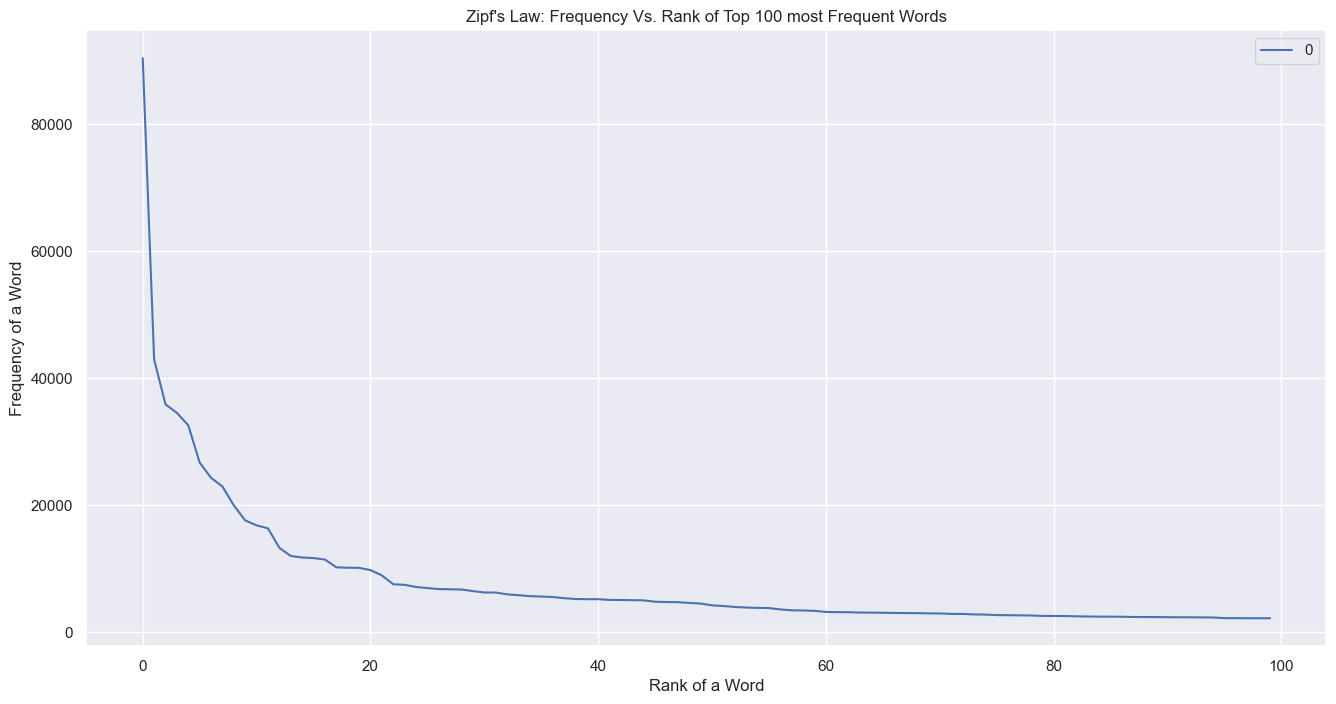

In [10]:
#Calculating and plotting the frequency distribution of most used 100 words

#Create top 100 words dict
top_100_words= dict(word_frequencies.most_common(100))

#plot frequency distribution
pd.Series(top_100_words).reset_index().plot(kind='line',figsize=(16,8),xlabel='Word Rank',ylabel='Word Frequency')
plt.title('Zipf\'s Law: Frequency Vs. Rank of Top 100 most Frequent Words')
plt.xlabel('Rank of a Word')
plt.ylabel('Frequency of a Word')

**At first glance the dataset appears to follow Zipf's law as the frequency of a word declines exponentially in relation to the rank of a word**

Zipf's law is an empirical law that often holds, approximately, when a list of measured values is sorted in decreasing order. It states that the value of the nth entry is inversely proportional to n.

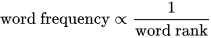

Source: https://en.wikipedia.org/wiki/Zipf%27s_law

## Let us now try to see if this holds true using a statistical model

Converting the above equation to log-log so that we can use linear regression. We will treat log(word_frequency) as our dependent variable and log(word_rank) as our independent variable(IV). We will estimate the coefficient of our IV and try to see if that is close to 1.


In [11]:
#Creating a dataframe containing top 100 words with their frequencies and ranks

word_frequency_tuples = list(top_100_words.items())
zipf_df = pd.DataFrame(word_frequency_tuples, columns=['Word', 'Word_Frequency'])
zipf_df['Word_Rank'] = range(1, len(zipf_df) + 1)
zipf_df


,Word,Word_Frequency,Word_Rank
0,the,90380,1
1,a,42925,2
2,and,35855,3
3,to,34504,4
4,i,32559,5
...,...,...,...
95,series,2169,96
96,because,2165,97
97,still,2159,98
98,thats,2155,99


In [12]:
# Converting "word_frequency" and "word_rank" variables to log-log and fitting a linear regression model. 
model=LinearRegression()

#taking coefficient based on the highest rank word
coeff = zipf_df['Word_Frequency'].iloc[99]*zipf_df['Word_Rank'].iloc[99]
model.fit(np.log(zipf_df['Word_Rank']/coeff).to_frame(),np.log(zipf_df['Word_Frequency']))

#evaluating the coefficient of IV
print("Coefficient of DV is:", model.coef_)

Coefficient of DV is: [-0.86390534]


### We can see that the coefficient of our IV i.e. log(word_rank) is very close to 1 and hence we can be pretty confident that our data follows zipf's law

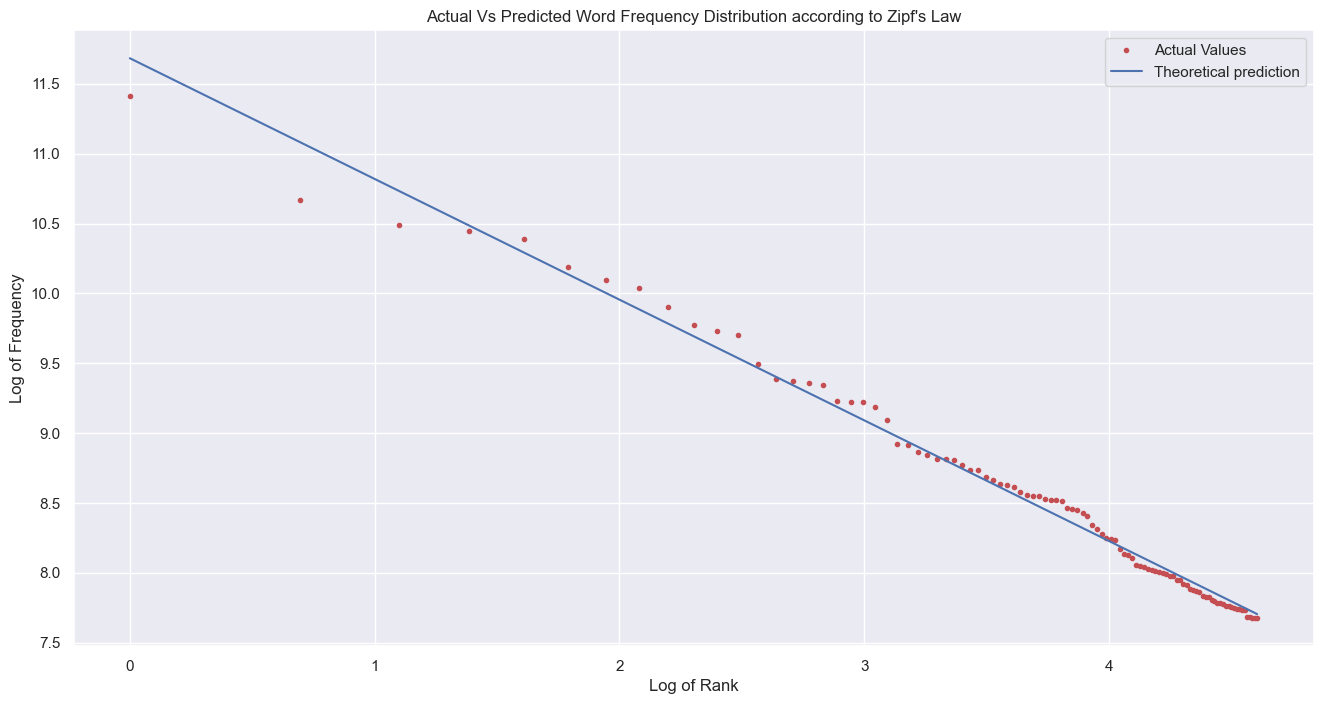

In [17]:
#plotting the actual data points vs the theoretical predicted values using Zipf's law for top100 words

plt.figure(figsize=(16,8))

plt.plot(np.log(zipf_df['Word_Rank']),np.log(zipf_df['Word_Frequency']),'r.',label='Actual Values ')
plt.plot(np.log(zipf_df['Word_Rank']),model.predict(np.log(zipf_df['Word_Rank']/coeff).to_frame()),label='Theoretical prediction')
plt.title('Actual Vs Predicted Word Frequency Distribution according to Zipf\'s Law')
plt.xlabel('Log of Rank')
plt.ylabel('Log of Frequency')

plt.legend()
plt.show()

### Task B: Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file. Even if a brand (e.g., BMW) is mentioned multiple times in a message, it should be counted as 1.   

In [13]:
df=pd.read_csv('edmunds.csv')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rachana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
stop = stopwords.words('english')
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)
df['body']=df['body'].str.lower()

df['body'] = df['body'].astype(str).apply(remove_stopwords)
print(df['body'])

0        `` bottom line think throw blanket cars terms ...
1        legacy gt another one 'm looking forward . 'd ...
2        `` g35 , tl & is300 worshipers gon na upset ne...
3        review mag articles relate specifically gt , m...
4        buy srt4 cheap , put $ 10k worth mods blow eve...
                               ...                        
17496    far know , , 3 series , infiniti g35 , acura t...
17497    honestly , good reasons might choose tl g35 , ...
17498    going include mazda stop , bring hyundai azera...
17499    know , described lesson learnt hard way . boug...
17500    `` . . .a base 328i . . .that miserable base e...
Name: body, Length: 17501, dtype: object


In [15]:
# Map the brand names to the car names
mapping_df = pd.read_csv('car_models_and_brands.csv')
model_to_brand = dict(zip(mapping_df['Model'], mapping_df['Brand']))
def replace_model_with_brand(comment):
    for model, brand in model_to_brand.items():
        comment = comment.replace(model, brand)
    return comment

df['body'] = df['body'].str.lower().apply(replace_model_with_brand)

In [16]:
brands=mapping_df['Brand'].unique()
values_to_remove = ['car', 'seat', 'problem','"hyundai,"','hyundai.','"kia,"','kia.','sedan']

brands = [x for x in brands if x not in values_to_remove]

In [17]:
brand_freq = {}

# Iterate through the "body" column of the target DataFrame
for _, row in df.iterrows():
    body_text = row['body']
    # Check for NaN values and skip them
    if not isinstance(body_text, str) and np.isnan(body_text):
        continue
    
    # Split the "body" text into words
    words = body_text.split()

    words = list(set(words))

    # Count the frequency of brand names in the "body" text
    for word in words:
        if word in brands:
            brand_freq[word] = brand_freq.get(word, 0) + 1

# Now, brand_freq dictionary contains the frequency counts of brand names in the "body" column
print(brand_freq)

{'acura': 1699, 'infiniti': 1234, 'bmw': 5702, 'honda': 1374, 'subaru': 543, 'audi': 1531, 'ford': 512, 'dodge': 218, 'toyota': 1154, 'volkswagen': 543, 'mitsubishi': 75, 'nissan': 776, 'mercedes-benz': 780, 'volvo': 577, 'hyundai': 352, 'chevrolet': 364, 'cadillac': 545, 'saturn': 48, 'chrysler': 180, 'mazda': 284, 'pontiac': 185, 'lincoln': 430, 'kia': 68, 'suzuki': 48, 'buick': 172, 'mercury': 21}


In [18]:
sorted_dict = sorted(brand_freq.items(), key=lambda item: item[1],reverse=True)
top_10_brands=sorted_dict[:10]
for brand, frequency in top_10_brands:
    print(f'{brand}: {frequency}')
top_10_list = [item[0] for item in top_10_brands]

bmw: 5702
acura: 1699
audi: 1531
honda: 1374
infiniti: 1234
toyota: 1154
mercedes-benz: 780
nissan: 776
volvo: 577
cadillac: 545


### Task C: Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post. In your code, ensure that a message is not counted in the lift calculations if the mentions of two brands are separated by more than, say, 5 or 7 words. 

In [19]:
def calculate_lift(brand1, brand2, co_mentions, individual_mentions, total_posts):
    if brand1 == brand2:
        return 0  # Lift ratio between the same brand is 0
    # Calculate lift using the formula: lift(brand1, brand2) = (P(brand1 and brand2) / (P(brand1) * P(brand2))) * N
    p_brand1_and_brand2 = co_mentions[brand1][brand2]
    p_brand1 = individual_mentions[brand1]
    p_brand2 = individual_mentions[brand2]
    if p_brand1 == 0 or p_brand2 == 0:
        return 0  
    else:
        return (p_brand1_and_brand2 / (p_brand1 * p_brand2)) * total_posts

In [20]:
def initialize(list1, list2):
    brand_mentions_per_post = {brand: set() for brand in list1 + list2}
    co_mentions = {}
    for brand1 in list1 + list2:
        co_mentions[brand1] = {}
        for brand2 in list1 + list2:
            co_mentions[brand1][brand2] = 0
    individual_mentions = {brand: 0 for brand in list1 + list2}
    lift_ratios = {}
    lift_already_calculated = set()
    return co_mentions, brand_mentions_per_post, individual_mentions, lift_ratios, lift_already_calculated

In [21]:
#co_mentions, brand_mentions_per_post, individual_mentions, lift_ratios, lift_already_calculated=initialize()

def calculate_lift_ratios_between_lists(df, list1, list2,window):
    co_mentions, brand_mentions_per_post, individual_mentions, lift_ratios, lift_already_calculated = initialize(list1,list2)
    total_posts = len(df)
    for _, row in df.iterrows():
        body_text = row['body']
        if not isinstance(body_text, str) and np.isnan(body_text):
            continue

        words = body_text.split()
        words = [word.lower() for word in words]
        mentioned_brands_in_post = set()
        co_brands_in_post = set()

        for i, word in enumerate(words):
            if word in list1 or word in list2:
                if word not in mentioned_brands_in_post:
                    individual_mentions[word] += 1
                    mentioned_brands_in_post.add(word)
                    k=min(i + window, len(words))
                    for j in range(i + 1, k):
                        if words[j] in list1 or words[j] in list2:
                            co_mentions[word][words[j]] += 1
                            co_mentions[words[j]][word] += 1

                elif word not in co_brands_in_post:
                    for j in range(i + 1, k ):
                        if words[j] in list1 or words[j] in list2:
                            co_mentions[word][words[j]] += 1
                            co_mentions[words[j]][word] += 1

    lift_df = pd.DataFrame(index=list1, columns=list2)

    for brand1 in list1:
        for brand2 in list2:
            pair = tuple(sorted([brand1, brand2]))
            if pair not in lift_already_calculated:
                lift_ratio = calculate_lift(brand1, brand2, co_mentions, individual_mentions, total_posts)
                lift_df.loc[brand1, brand2] = lift_ratio
                lift_ratios[pair] = lift_ratio	
                lift_already_calculated.add(pair)
    sorted_lift_ratios = sorted(lift_ratios.items(), key=lambda x: x[1], reverse=True)

    return lift_df,sorted_lift_ratios


In [24]:
lift_df,sorted_lift_ratios=calculate_lift_ratios_between_lists(df,top_10_list, top_10_list, 12)
sorted_lift_ratios=sorted_lift_ratios[:10]
lift_df

,bmw,acura,audi,honda,infiniti,toyota,mercedes-benz,nissan,volvo,cadillac
bmw,0,0.856289,1.258984,0.464635,1.114291,0.494701,1.479547,0.344107,0.67024,1.154498
acura,NaN,0,1.87042,1.971689,2.696229,0.419529,1.25458,0.849548,1.285364,1.814447
audi,NaN,NaN,0,0.482535,2.075012,0.564621,2.667255,0.294616,3.902816,2.412065
honda,NaN,NaN,NaN,0,0.402555,3.951421,0.571544,3.808048,1.015449,0.373938
infiniti,NaN,NaN,NaN,NaN,0,0.368692,1.309139,0.877258,1.130654,2.055788
toyota,NaN,NaN,NaN,NaN,NaN,0,0.583289,3.752291,0.998769,0.25044
mercedes-benz,NaN,NaN,NaN,NaN,NaN,NaN,0,0.231311,4.238566,3.375869
nissan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.797973,0.455195
volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.113065
cadillac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Task D: Show the brands on a multi-dimensional scaling (MDS) map 

In [31]:

df_top10 = pd.DataFrame(sorted_lift_ratios[:10], columns=['Brands', 'Lift Value'])

# Split the 'Brands' column into separate columns
df_top10[['Brand 1', 'Brand 2']] = pd.DataFrame(df_top10['Brands'].tolist(), index=df_top10.index)

# Drop the original 'Brands' column
df_top10.drop('Brands', axis=1, inplace=True)

# Print the resulting DataFrame
df_top10

,Lift Value,Brand 1,Brand 2
0,4.238566,mercedes-benz,volvo
1,3.951421,honda,toyota
2,3.902816,audi,volvo
3,3.808048,honda,nissan
4,3.752291,nissan,toyota
5,3.375869,cadillac,mercedes-benz
6,2.696229,acura,infiniti
7,2.667255,audi,mercedes-benz
8,2.412065,audi,cadillac
9,2.075012,audi,infiniti


C:\Users\Mayank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


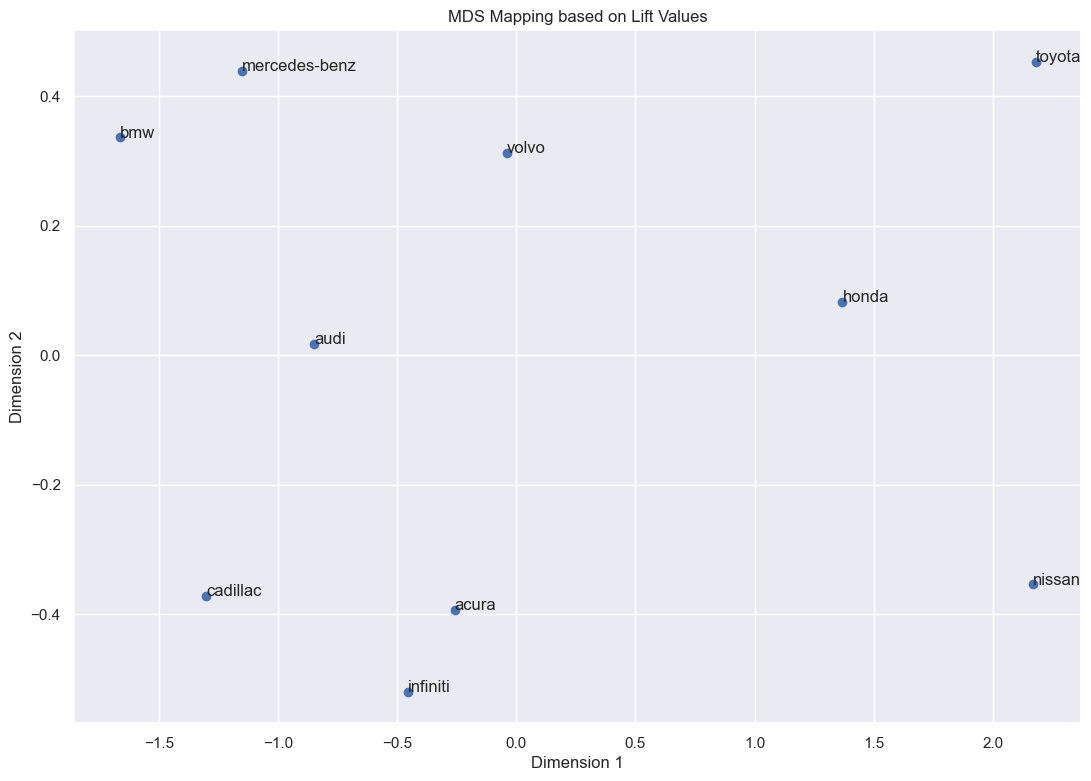

In [76]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Extract the unique brand names
brands = set()
for lift_item, _ in sorted_lift_ratios:
    brands.update(lift_item)
brands = list(brands)

# Create an empty dissimilarity matrix
n = len(brands)
dissimilarity_matrix = np.zeros((n, n))

# Fill the dissimilarity matrix with lift values
for i in range(n):
    for j in range(n):
        if i != j:
            brand_pair = (brands[i], brands[j])
            # Find the lift value for the brand pair
            for lift_item, lift_value in sorted_lift_ratios:
                if brand_pair == lift_item or brand_pair == lift_item[::-1]:
                    dissimilarity_matrix[i, j] = 1 / lift_value  # You may need to adjust this scaling
                    break

# Initialize the MDS model
mds = MDS(n_components=2, dissimilarity="precomputed")

# Fit the data and perform MDS mapping
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS results with labels
plt.figure(figsize=(13, 9))
plt.scatter(mds_result[:, 0], mds_result[:, 1])
for i, brand in enumerate(brands):
    plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))
plt.title("MDS Mapping based on Lift Values")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Task E: What insights can you offer to your client from your analyses in Tasks C and D? 

**Insights from Task C (Lift Analysis):**

1. **Brand Associations**: The lift values indicate the strength of associations between different car brands mentioned in social media conversations. For instance, Mercedes-Benz and Volvo have a high lift value of 4.63, suggesting that these brands are frequently mentioned together in discussions. Honda and Toyota also have a strong association with a lift value of 4.16. This information can help your client understand which brands are often discussed in relation to each other and identify potential competitors or collaboration opportunities.

2. **Distinctiveness**: Lower lift values suggest less strong associations between brands. For example, Honda and Infiniti have a lift value of 1.66, indicating that they are mentioned together less frequently. Understanding these distinctions can help your client identify which brands have a more unique or separate market presence.

3. **Potential Partnerships**: Brands with moderate lift values may consider exploring partnerships or collaborations. For example, Audi and Cadillac have a lift value of 2.18, indicating some association. Your client could advise these brands to explore potential co-marketing or co-branding opportunities to leverage this association.

**Insights from Task D (MDS Map Analysis):**

1. **Brand Clustering**: The MDS map shows how different car brands are positioned in terms of similarity in social media conversations. The cluster of BMW, Audi, Mercedes, and Cadillac suggests that these brands are closely related in the context of the entry-level luxury car market. They may share similar customer perceptions, characteristics, or competition.

2. **Distinct Clusters**: The presence of distinct clusters on the MDS map indicates that some brands are more closely related to each other than to others. For example, Nissan, Honda, and Toyota form a separate cluster, indicating that they may be perceived differently or have different customer bases compared to the luxury brands in the first cluster.

**Recommendations:**

1. **Competitive Analysis**: Based on the brand associations identified in Task C, your client can perform a more in-depth competitive analysis of specific brand pairs with high lift values. This analysis can include examining consumer sentiment, product features, and market positioning to gain a deeper understanding of the relationships between these brands.

2. **Market Segmentation**: The MDS map from Task D can inform market segmentation strategies. Your client can consider targeting specific customer segments based on their preferences for certain brand clusters. For example, the cluster of luxury brands (BMW, Audi, Mercedes, Cadillac) may appeal to a different audience than the cluster of Nissan, Honda, and Toyota.

3. **Partnership Opportunities**: Brands with moderate lift values, such as Audi and Cadillac, may explore partnership opportunities to cross-promote or collaborate on marketing campaigns. This can help them leverage the existing associations between their brands to reach a broader audience.

4. **Consumer Perception Analysis**: Use sentiment analysis and social media monitoring tools to gain insights into how consumers perceive and discuss these brands. Are there common themes or pain points that emerge in discussions about certain brands? This information can guide brand improvement strategies.

In summary, your analysis provides valuable insights into brand associations and positioning in the entry-level luxury car market. These insights can inform marketing, partnership, and segmentation strategies to help your client make data-driven decisions and stay competitive in the industry.

### Task F: What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS plot for this question. 

### Task G: What advice will you give to your client from Task F? 

### Task H: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [36]:
# Taking sensible synonynms of buy or own from references : https://www.thesaurus.com/browse/own , https://www.thesaurus.com/browse/buy, https://www.collinsdictionary.com/us/dictionary/english-thesaurus/buy, https://chat.openai.com/

buy = pd.read_excel("buy or own synonymns.xlsx")
buy.head()
buy_list= list(buy['Synonyms'])
buy_list[:15]

['purchase',
 'acquire',
 'obtain',
 'take',
 'secure',
 'procure',
 'score',
 'invest',
 'shop',
 'gain',
 'attain',
 'reserve',
 'lease',
 'possession',
 'ownership']

In [37]:
# Now for our top 10 brands, lets find the lift of those brands with these 'aspiration' related terms
# The logic is to calculate lift of all 'aspirational' words with each of the top 10 brands, then calculate average lift values of all 'aspirational' words for each brand

# Load the "edmunds" CSV file containing messages
edmunds_df = pd.read_csv('edmunds.csv')
edmunds_messages = edmunds_df['body']

# Initialize dictionaries to store co-mentions and individual counts
co_mentions = {brand: {synonym: 0 for synonym in buy_list} for brand in top_10_list}
brand_counts = {brand: 0 for brand in top_10_list}
synonym_counts = {synonym: 0 for synonym in buy_list}

# Iterate through the messages and count co-mentions and individual counts
for message in edmunds_messages:
    for brand in top_10_list:
        for synonym in buy_list:
            # Convert to strings
            message = str(message)
            brand = str(brand)
            synonym = str(synonym)
            
            if brand.lower() in message.lower() and synonym.lower() in message.lower():
                co_mentions[brand][synonym] += 1
                brand_counts[brand] += 1
                synonym_counts[synonym] += 1

# Calculate lift ratios for each combination
lift_ratios = {}

for brand, synonym in product(top_10_list, buy_list):
    co_mention_count = co_mentions[brand][synonym]
    brand_count = brand_counts[brand]
    synonym_count = synonym_counts[synonym]
    
    # Calculate lift ratio
    if co_mention_count == 0:
        lift_ratio = 0.0
    else:
        lift_ratio = (co_mention_count * len(edmunds_df)) / (brand_count * synonym_count)
    
    lift_ratios[(brand, synonym)] = lift_ratio

# Calculate average lift ratios for each car brand
average_lift_ratios = {brand: 0.0 for brand in top_10_list}

for brand in top_10_list:
    total_lift_ratio = sum(lift_ratios[(brand, synonym)] for synonym in buy_list)
    average_lift_ratios[brand] = total_lift_ratio / len(buy_list)

# Convert average lift ratios into a list of tuples
average_lift_ratios_list = [(brand, ratio) for brand, ratio in average_lift_ratios.items()]

# Sort the list in descending order based on lift ratios
sorted_average_lift_ratios = sorted(average_lift_ratios_list, key=lambda x: x[1], reverse=True)

# Print the sorted average lift ratios
for brand, ratio in sorted_average_lift_ratios:
    print(f"Brand: {brand}, Average Lift Ratio: {ratio}")

Brand: mercedes-benz, Average Lift Ratio: 2.9130044188539177
Brand: bmw, Average Lift Ratio: 2.1085740206982186
Brand: audi, Average Lift Ratio: 1.7313680502449107
Brand: cadillac, Average Lift Ratio: 1.678064879363812
Brand: nissan, Average Lift Ratio: 1.5829173140904382
Brand: toyota, Average Lift Ratio: 1.5729547281932106
Brand: acura, Average Lift Ratio: 1.5694223040971313
Brand: honda, Average Lift Ratio: 1.3172634980569307
Brand: infiniti, Average Lift Ratio: 1.1749151004653455
Brand: volvo, Average Lift Ratio: 1.1169670311674837


From our analysis, we found that the most aspirational brand was Mercedes Benz. This means that people associated words which depicted their aspire to own a Mercedes the most between January 2004 and March 2008. We can also strongly associate the attributes _____ with Mercedes which tells us that ____.

In [106]:
print(df['body'])

0       braking - sorry 70 0 braking 189 retoyotad c &...
1       new 2004 honda drove driveway last night . goo...
2       love numbers , compare performance price numbe...
3       kd , people buy tl honda , reason bought 330 3...
4       ppontiac8477 ... prove point . luxury primary ...
                              ...                        
4995    `` meaningless '' guess 's meaningless actuall...
4996    guess everyone hung whole msrp value thing . g...
4997    please stop yelling ! consider used chevrolet ...
4998    response exepected ... discounting areas bmw e...
4999    `` please mountain , curvy , wavy road nonsens...
Name: body, Length: 5000, dtype: object


In [14]:
df

,author,body,dates
0,chrisboth,`` bottom line think throw blanket car terms p...,"January 27, 2004"
1,qbrozen,subaru gt another one 'm looking forward . 'd ...,"January 8, 2004"
2,chrisboth,"`` pontiac5 , tl & is300 worshipers gon na ups...","January 8, 2004"
3,buddhabman,"review mag articles relate specifically gt , m...","January 8, 2004"
4,kdshapiro,"buy srt4 cheap , put $ 10k worth mods blow eve...","January 8, 2004"
...,...,...,...
17496,sjaieve,"far know , , 3 series , infiniti pontiac5 , ac...","March 11, 2008"
17497,riorebel,"honestly , good reasons might choose tl pontia...","March 11, 2008"
17498,plekto,"going include mazda stop , bring hyundai hyund...","March 11, 2008"
17499,sjaieve,"know , described lesson learnt hard way . boug...","March 11, 2008"


In [107]:
df_new=pd.DataFrame()
from nltk import word_tokenize, FreqDist

In [108]:
import string 
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

# Remove punctuations from the 'body' column
df['body'] = df['body'].apply(remove_punctuation)

In [109]:
df_new['tokenized_text'] = df['body'].apply(word_tokenize)

# Flatten the list of tokenized words
all_words = [word for sublist in df_new['tokenized_text'] for word in sublist]

# Calculate word frequencies
freq_dist = FreqDist(all_words)

# Get the most common words (you can adjust the number)
num_most_common = 100
most_common_attributes = freq_dist.most_common(num_most_common)

# Extract the attribute names (words) from the most common words
top_attributes = [word for word, frequency in most_common_attributes]

print("Top", num_most_common, "Most Frequently Mentioned Attributes/Features:")
for attribute in top_attributes:
    print(attribute)

Top 100 Most Frequently Mentioned Attributes/Features:
car
s
nt
bmw
tl
like
would
one
pontiac5
get
think
drive
3
better
sedan
new
m
much
performance
acura
people
audi
even
good
driving
really
know
best
want
luxury
well
rwd
honda
also
still
330i
engine
series
way
say
infiniti
could
time
ve
price
make
see
fwd
lexus
d
handling
buy
great
go
awd
re
hp
interior
ll
power
g
many
nissan
years
back
going
tires
manual
less
test
look
toyota
got
right
ca
take
may
feel
sport
never
two
toyotad
subaru
sales
point
need
2
seat
sure
different
cts
thing
lot
year
maybe
road
torque
5
little
around


In [28]:
attributes=["performance","drive","luxury","driving","price","interior"]
top_10_lift,lift_ratios=calculate_lift_ratios_between_lists(df,top_10_list[:5], attributes,30)
top_10_lift

,performance,drive,luxury,driving,price,interior
bmw,1.907702,1.283274,1.374045,1.545154,1.950953,1.374198
acura,1.245045,1.363075,1.99444,0.852515,1.267884,1.334417
audi,1.464463,1.556993,2.014994,1.452237,1.23901,3.377368
honda,1.308899,1.213334,2.430558,1.920325,1.567783,1.466715
infiniti,0.995139,1.026997,1.444423,0.695286,1.337464,1.772792
